In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [44]:
N_1 = 1000
q = 4 * np.random.rand(N_1, 1) * 2 * np.pi
X_1 = np.concatenate((np.sin(q), np.cos(q)), axis=1) * (
    0 + np.random.normal(scale=0.7, size=(N_1, 1))
)

N_2 = 2000
q = 4 * np.random.rand(N_2, 1) * 2 * np.pi
X_2 = np.concatenate((np.sin(q), np.cos(q)), axis=1) * (
    3 + np.random.normal(scale=0.7, size=(N_2, 1))
)

N_3 = 3000
q = 4 * np.random.rand(N_3, 1) * 2 * np.pi
X_3 = np.concatenate((np.sin(q), np.cos(q)), axis=1) * (
    6 + np.random.normal(scale=0.7, size=(N_3, 1))
)

In [45]:
N_star = 4000
q = 4 * np.random.rand(N_star, 1) * 2 * np.pi
X_star = (
    np.concatenate((np.sin(q), np.cos(q)), axis=1)
    * (4 * np.random.rand(N_star, 1))
)

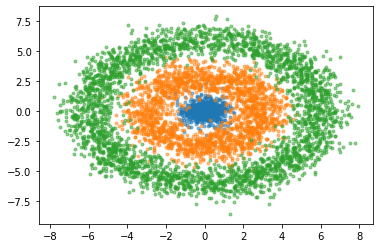

In [46]:
plt.plot(*X_1.T, ".", alpha=0.5)
plt.plot(*X_2.T, ".", alpha=0.5)
plt.plot(*X_3.T, ".", alpha=0.5);

In [47]:
X = np.vstack((X_1, X_2, X_3))
N = len(X)

In [48]:
@numba.njit
def rbf_kernel(x: np.ndarray, y: np.ndarray) -> np.float:
    """vectorized RBF kernel"""
    result = np.expand_dims(x, 1) - y
    result = -0.5 * result ** 2
    result = result.sum(axis=2)
    return np.exp(result)

In [49]:
class KernelPCA:
    """Nonlinear principal component analysis using a kernel.

    Attributes
    ----------
        kernel : callable
            Vectorized Mercer kernel function for data points.
        data : np.ndarray
            Data for the model to fit.
        gram_matrix : np.ndarray
            The gram matrix.
        k_bar : np.ndarray
            The column-wise average of the gram matrix
        eigvecs : np.ndarray
            The eigenvectors of the gram matrix. Sorted backwards by eigenvalue
        eigvals : np.ndarray
            The eigenvalues of the gram matrix. Sorted backwards.
        epsilon : float
            Values less extreme to consider as 0
    """

    kernel: callable
    data: np.ndarray
    gram_matrix: np.ndarray
    k_bar: np.ndarray
    eigvecs: np.ndarray
    eigvals: np.ndarray
    n_components: int
    epsilon: float

    @property
    def n(self) -> int:
        return len(self.data)

    def __init__(self, data: np.ndarray, kernel: callable,  epsilon: float = 0.0000001):
        """Initialize the class and fit data.
        
        Parameters
        ----------
        data : np.ndarray
            The data to fit the model.
        kernel : callable
            Note that the kernel must take in two 1-d arrays, not 2-d arrays. Taking
            2-d arrays (and thus vectorizing) would probably be faster.
        """
        self.kernel = kernel
        self.data = data
        self.epsilon = epsilon

        # Create the Gram matrix $K$.
        self.gram_matrix = self.kernel(self.data, self.data)
        h = np.eye(self.n) - np.ones_like(self.n) / self.n
        # Find the centered Gram matrix $K$.
        self.centered_gram_matrix = h @ self.gram_matrix @ h

        # Fit the model
        eigvals, eigvecs = np.linalg.eigh(self.centered_gram_matrix)
        # Get rid of small eigenvalues and vectors.
        idx = abs(eigvals) > self.epsilon
        self.eigvals = eigvals[idx][::-1]  # Order from greatest to least.
        self.eigvecs = eigvecs[:, idx][:, ::-1]

    def predict(self, x: np.ndarray, n_components: int = 2) -> np.ndarray:
        """Find the embeddings for new data.

        Parameters
        ----------
        x : np.ndarray
            The new data
        n_components : int
            The number of dimensions to reduce the data.

        Returns
        -------
        z_star : np.ndarray
            The embeddings for `x`.
        """
        # Gram matrix where rows are for `x` and columns are for `self.data`.
        k_star = self.kernel(x, self.data)

        # This is a bit complicated, but basically we are trying to find
        # $(\phi_i - \bar\phi)\Phi U V^{-0.5}$; i.e. we are centering the data in the
        # feature (phi) space and then projecting it onto the principal
        # components.
        z_star = (
            k_star
            - np.ones((len(k_star), 1)) @ self.gram_matrix.mean(axis=1).reshape(1, -1)
            - k_star.mean(axis=1).reshape(-1, 1) @ np.ones((1, len(self.data)))
            + self.gram_matrix.mean() * np.ones_like(k_star)
        )
        z_star = (
            z_star
            @ self.eigvecs[:, :n_components]
            @ np.diag(self.eigvals[:n_components] ** -0.5)
        )
        return z_star

In [50]:
kpca = KernelPCA(data=X, kernel=rbf_kernel)

In [51]:
z_star = kpca.predict(X_star)
# z = kpca.predict(X)

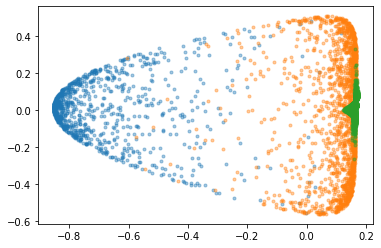

In [52]:
plt.plot(*kpca.predict(X_1).T, ".", alpha=0.4)
plt.plot(*kpca.predict(X_2).T, ".", alpha=0.4)
plt.plot(*kpca.predict(X_3).T, ".", alpha=0.4);
# plt.plot(*z_star.T, ".", alpha=0.4);